In [ ]:
!pip install hampel
import os
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/LOBster'

os.chdir(path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
import pandas as pd
import datetime
import numpy as np
import pywt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import scipy
import hampel

In [ ]:
#Orderbook & Message
orderbook = pd.read_csv("MSFT/MSFT_2012-06-21_34200000_37800000_orderbook_50.csv")
message = pd.read_csv("MSFT/MSFT_2012-06-21_34200000_37800000_message_50.csv")

#Orderbook data
cols = ['Ask Price', 'Ask Size', 'Bid Price', 'Bid Size']
levels = list(range(1, 51))
new_cols = new_cols = [f'{c} {l}' for l in levels for c in cols]
orderbook.columns = new_cols

#Message data
message.columns = ['Time', 'Type', 'Order ID', 'Size', 'Price', 'Direction']

In [ ]:
#Merge both datasets
data = pd.concat([message, orderbook], axis=1)

#Function to convert a time in seconds to a time in hours
def convert_time_to_hours(time_in_seconds):
  return (datetime.datetime.min + datetime.timedelta(seconds=float(time_in_seconds))).time()

#Drop rows with missing values in the Time column
data = data.dropna(subset=['Time'])

#Convert the Time column to a numeric type and apply the conversion function
data['Timestamp'] = pd.to_numeric(data['Time'], errors='coerce').apply(convert_time_to_hours)

print("Tamanho: " + str(len(data)))

Tamanho: 141506


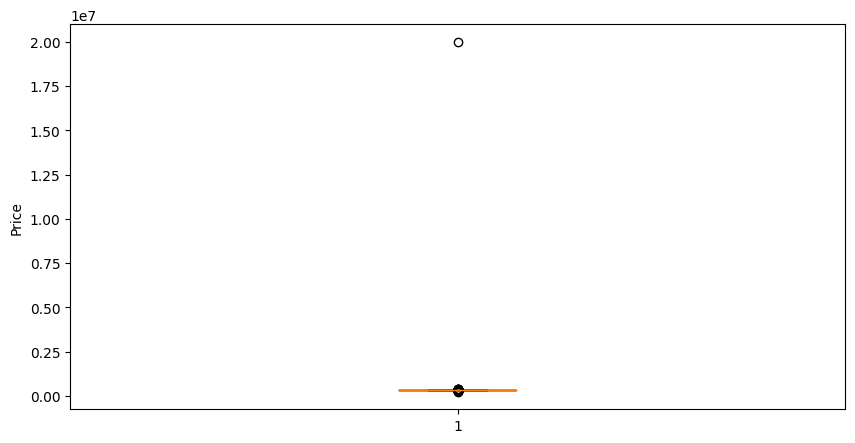

In [ ]:
#Boxplot (Dados Brutos)
fig, ax = plt.subplots(figsize=(10, 5))
prices = data['Price']

ax.boxplot(prices)

ax.set_title('')
ax.set_ylabel('Price')

plt.show()

In [ ]:
#Deletar ordens onde Type é Cancellation/Deletion/Hidden Execution/Trading Halts
data = data[~data['Type'].isin([2, 3, 5, 7])]

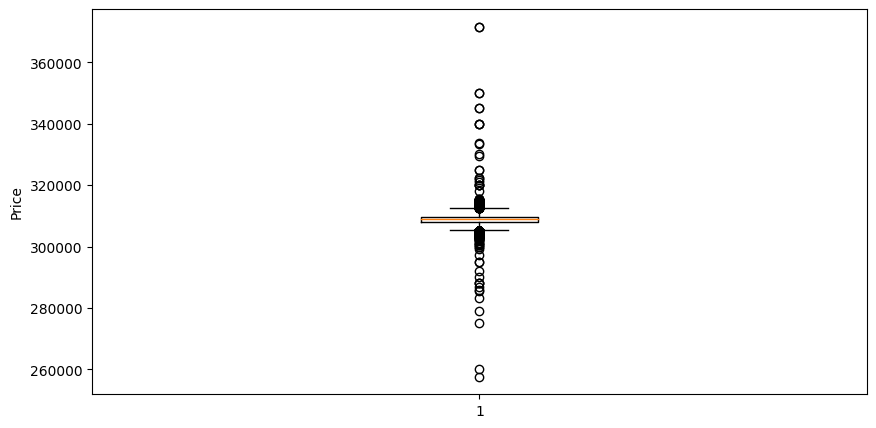

In [ ]:
#Boxplot após deleção de ordens
fig, ax = plt.subplots(figsize=(10, 5))
prices = data['Price']

ax.boxplot(prices)

ax.set_title('')
ax.set_ylabel('Price')

plt.show()

In [ ]:
#Método Percentil
#https://www.sciencedirect.com/science/article/abs/pii/S0304405X18300278

price = data['Price']

#Calcular o 1 e 99 percentis do dataset
percentiles = price.quantile([0.01, 0.99])
outliers = data[(price < percentiles.loc[0.01]) | (price > percentiles.loc[0.99])]
data = data[(price >= percentiles.loc[0.01]) & (price <= percentiles.loc[0.99])]

Z-Score < -3: 76505
Z-Score > 3: 76505


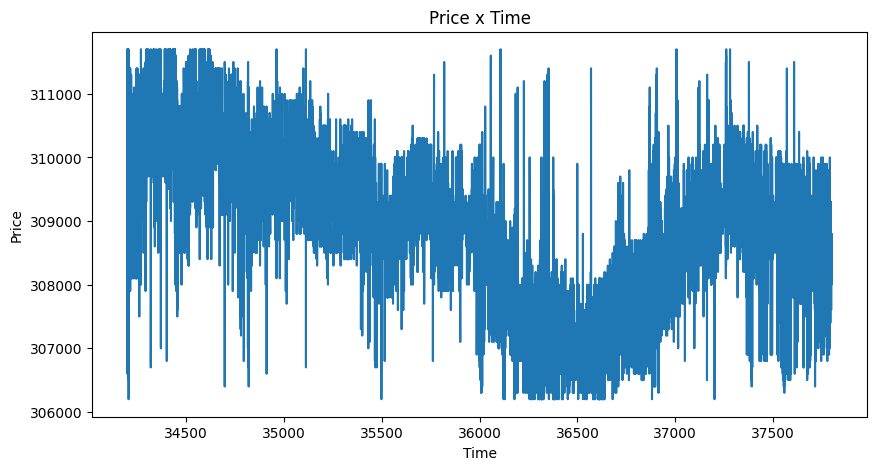

75068


In [ ]:
#Gráfico após Método Percentil
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data['Time'], data['Price'])

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Price x Time')

plt.show()

print(len(data))

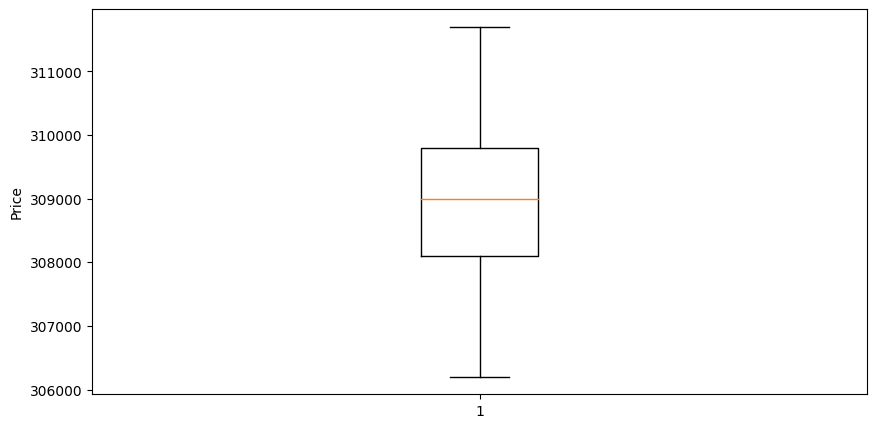

In [ ]:
#Boxplot após Método Percentil
fig, ax = plt.subplots(figsize=(10, 5))
prices = data['Price']

ax.boxplot(prices)

ax.set_title('')
ax.set_ylabel('Price')

plt.show()

In [ ]:
#Filtro de Hampel (Excluir: Prices > MAD)
ts = data['Price']
ts.reset_index(drop=True, inplace=True)
outlier_indices = hampel.hampel(ts, window_size=5, n=2)
data.reset_index(drop=True, inplace=True)
index_to_drop = outlier_indices
data = data[~data.index.isin(index_to_drop)]

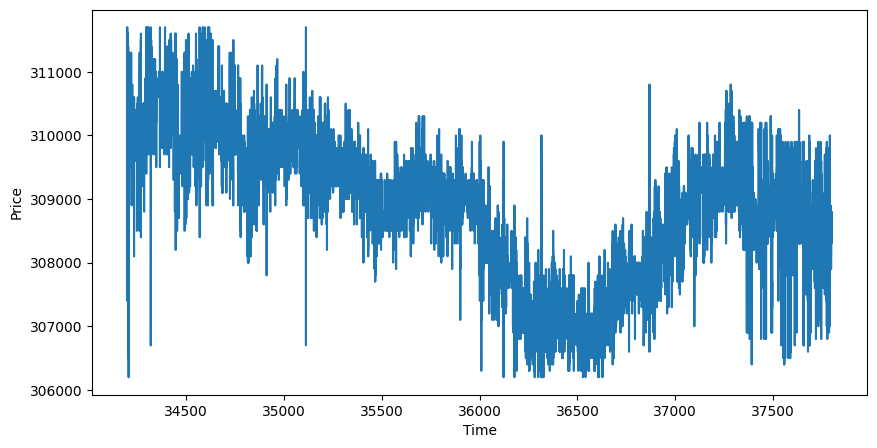

27260


In [ ]:
#Gráfico após Filtro de Hampel
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data['Time'], data['Price'])

ax.set_xlabel('Time')
ax.set_ylabel('Price')

plt.show()

print(len(data))

In [ ]:
#Criação Order Flow Imbalance
#https://medium.com/@eliquinox/order-flow-analysis-of-cryptocurrency-markets-b479a0216ad8
def ofi(quotes):
    qdf = quotes.copy().reset_index()

    qdf['Mid-Price Change'] = ((qdf['Bid Price 1'] + qdf['Ask Price 1']) / 2).diff().div(0.01)
    
    qdf['prev_Bid Price 1'] = qdf['Bid Price 1'].shift()
    qdf['prev_Bid Size 1'] = qdf['Bid Size 1'].shift()
    qdf['prev_Ask Price 1'] = qdf['Ask Price 1'].shift()
    qdf['prev_Ask Size 1'] = qdf['Ask Size 1'].shift()

    qdf.dropna(inplace=True)
    
    qdf['OFI'] = 0
    
    bid_geq = qdf['Bid Price 1'] >= qdf['prev_Bid Price 1']
    bid_leq = qdf['Bid Price 1'] <= qdf['prev_Bid Price 1']
    ask_geq = qdf['Ask Price 1'] >= qdf['prev_Ask Price 1']
    ask_leq = qdf['Ask Price 1'] <= qdf['prev_Ask Price 1']
    
    qdf['OFI'].loc[bid_geq] += qdf['Bid Size 1'].loc[bid_geq]
    qdf['OFI'].loc[bid_leq] -= qdf['prev_Bid Size 1'].loc[bid_leq]
    qdf['OFI'].loc[ask_geq] += qdf['prev_Ask Size 1'][ask_geq]
    qdf['OFI'].loc[ask_leq] -= qdf['Ask Size 1'][ask_leq]
    
    return qdf

data = ofi(data)
print(data.head)

<bound method NDFrame.head of         index          Time  Type  Order ID  Size   Price  Direction  \
1           1  34200.015248     1  16116658   100  310400         -1   
2           2  34200.015442     1  16116704   100  310500         -1   
3           3  34200.015789     1  16116752   100  310600         -1   
4           4  34200.016300     1  16116815   100  310700         -1   
5           9  34200.020733     1  16118193   100  310300         -1   
...       ...           ...   ...       ...   ...     ...        ...   
75063  141498  37799.775937     1  74173880   600  308500         -1   
75064  141500  37799.776656     1  74173941   100  308500         -1   
75065  141501  37799.780171     1  74174637   330  308500         -1   
75066  141504  37799.781979     1  74175260    80  308500         -1   
75067  141505  37799.787425     1  74175870   500  308600         -1   

       Ask Price 1  Ask Size 1  Bid Price 1  ...  Bid Size 50  \
1           309900        3788       309

<ipython-input-15-fcd9c02a64d4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qdf['OFI'].loc[bid_geq] += qdf['Bid Size 1'].loc[bid_geq]
<ipython-input-15-fcd9c02a64d4>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qdf['OFI'].loc[bid_leq] -= qdf['prev_Bid Size 1'].loc[bid_leq]
<ipython-input-15-fcd9c02a64d4>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qdf['OFI'].loc[ask_geq] += qdf['prev_Ask Size 1'][ask_geq]
<ipython-inpu

In [ ]:
#Criação das Bandas de Bollinger
!pip install ta
import ta

def calculate_bollinger_bands(data, window):
    indicator_bb = ta.volatility.BollingerBands(data['Price'], window=window, window_dev=2)
    return indicator_bb.bollinger_mavg(), indicator_bb.bollinger_hband(), indicator_bb.bollinger_lband()
data['BB_MA'], data['BB_High'], data['BB_Low'] = calculate_bollinger_bands(data, 10)